In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load('patch_camelyon', download=False, with_info=True,
                            data_dir='/content/drive/My Drive/Colab Notebooks')
#print(pcam_info)

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
# Code from https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 2)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=5e-4),
        metrics=['accuracy']
    )
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 94, 94, 32)        608       
_________________________________________________________________
batch_normalization_21 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_22 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_22 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 46, 46, 32)       

In [0]:
import random

def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.rot90(image, random.randint(0,3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.expand_dims(image, 0)
    image = tf.image.sobel_edges(image)
    image = tf.squeeze(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_cb = ModelCheckpoint("/content/drive/My Drive/old_kaggle_model_Adam.h5",
                                      monitor='val_loss', mode='min', verbose=2, save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

In [34]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline, callbacks=callbacks_list,
                 verbose=2, epochs=20, steps_per_epoch=4096, validation_steps=256)

Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.42767, saving model to /content/drive/My Drive/old_kaggle_model_Adam.h5
4096/4096 - 276s - loss: 0.4429 - accuracy: 0.8012 - val_loss: 0.4277 - val_accuracy: 0.8062
Epoch 2/20

Epoch 00002: val_loss improved from 0.42767 to 0.31491, saving model to /content/drive/My Drive/old_kaggle_model_Adam.h5
4096/4096 - 272s - loss: 0.3308 - accuracy: 0.8594 - val_loss: 0.3149 - val_accuracy: 0.8641
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.31491
4096/4096 - 275s - loss: 0.2885 - accuracy: 0.8810 - val_loss: 0.3772 - val_accuracy: 0.8350
Epoch 4/20

Epoch 00004: val_loss improved from 0.31491 to 0.27669, saving model to /content/drive/My Drive/old_kaggle_model_Adam.h5
4096/4096 - 273s - loss: 0.2659 - accuracy: 0.8926 - val_loss: 0.2767 - val_accuracy: 0.8826
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.27669
4096/4096 - 262s - loss: 0.2501 - accuracy: 0.9001 - val_loss: 0.3079 - val_accuracy: 0.8666
Epoch 6/20

Ep

In [35]:
best_model = load_model("/content/drive/My Drive/old_kaggle_model_Adam.h5")
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(best_model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8891


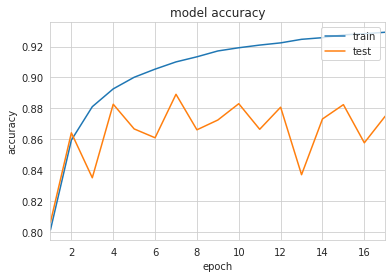

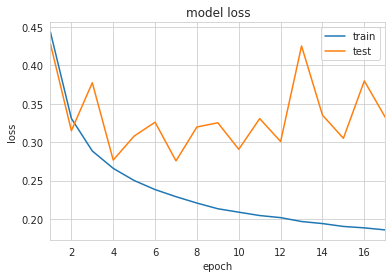

In [36]:
dim = np.arange(1, len(hist.history['accuracy']) + 1)
plt.figure()
plt.xlim(1, len(hist.history['accuracy']))
plt.plot(dim, hist.history['accuracy'])
plt.plot(dim, hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.xlim(1, len(hist.history['accuracy']))
plt.plot(dim, hist.history['loss'])
plt.plot(dim, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Import modules
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

In [38]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = best_model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,1]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.88800048828125


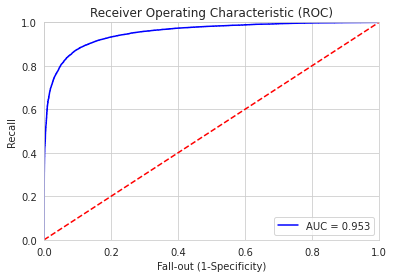

In [39]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

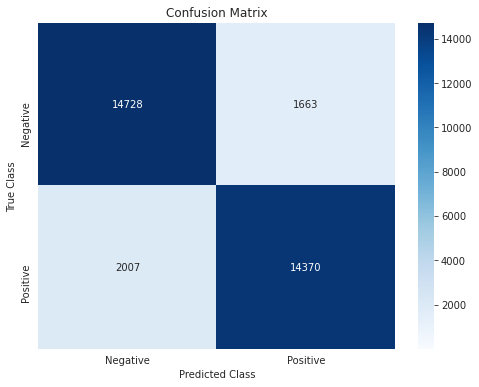

In [40]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()